In [246]:
# Import the modules, read the dataset and create a Pandas DataFrame.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.linear_model import LinearRegression



# Read the dataset
taxi_df = pd.read_csv("exam_data.csv")
taxi_df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,GoodTip,Extra,Cash
0,1,1,2016-02-19 20:50:19,2016-02-19 20:59:25,1,2.30,-73.954231,40.763958,1,N,...,9.5,0.5,0.5,0.0,0.0,0.3,10.8,False,True,True
1,2,1,2016-02-07 16:20:36,2016-02-07 16:33:14,2,1.30,-73.992416,40.694214,1,N,...,9.0,0.0,0.5,0.0,0.0,0.3,9.8,False,False,True
2,3,1,2016-02-19 20:52:38,2016-02-19 21:02:27,1,1.80,-73.984863,40.741970,1,N,...,8.5,0.5,0.5,1.5,0.0,0.3,11.3,False,True,False
3,4,1,2016-02-19 20:53:28,2016-02-19 21:07:49,1,2.40,-73.998344,40.740376,1,N,...,11.5,0.5,0.5,3.2,0.0,0.3,16.0,True,True,False
4,5,2,2016-02-19 20:53:50,2016-02-19 20:59:51,1,1.09,-73.993179,40.729870,1,N,...,6.0,0.5,0.5,1.2,0.0,0.3,8.5,False,True,False


In [247]:
#To get the information about Data Set
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28454 entries, 0 to 28453
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             28454 non-null  int64  
 1   VendorID               28454 non-null  int64  
 2   tpep_pickup_datetime   28454 non-null  object 
 3   tpep_dropoff_datetime  28454 non-null  object 
 4   passenger_count        28454 non-null  int64  
 5   trip_distance          28454 non-null  float64
 6   pickup_longitude       28454 non-null  float64
 7   pickup_latitude        28454 non-null  float64
 8   RatecodeID             28454 non-null  int64  
 9   store_and_fwd_flag     28454 non-null  object 
 10  dropoff_longitude      28454 non-null  float64
 11  dropoff_latitude       28454 non-null  float64
 12  payment_type           28454 non-null  int64  
 13  fare_amount            28454 non-null  float64
 14  extra                  28454 non-null  float64
 15  mt

## Data Cleaning

In [248]:
# First we can remove the unnamed column from the data set
taxi_df = taxi_df.drop(columns=['Unnamed: 0'], axis=1) 

In [249]:
# some trips report 0 tip. it is assumed that these tips were paid in cash.
# for this study we drop all these rows
taxi_df = taxi_df[taxi_df['tip_amount'] > 0]

In [250]:
# we also remove some outliers, namely those where the tip was larger than the fare cost
taxi_df = taxi_df[(taxi_df['tip_amount'] <= taxi_df['fare_amount'])]

In [251]:
# we remove trips with very large fare cost
taxi_df = taxi_df[((taxi_df['fare_amount'] >=2) & (taxi_df['fare_amount'] < 200))]

In [252]:
# we drop variables that include the target variable in it, namely the total_amount
clean_taxi_df = taxi_df.drop(['total_amount'], axis=1)

In [253]:
clean_taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18442 entries, 2 to 28451
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               18442 non-null  int64  
 1   tpep_pickup_datetime   18442 non-null  object 
 2   tpep_dropoff_datetime  18442 non-null  object 
 3   passenger_count        18442 non-null  int64  
 4   trip_distance          18442 non-null  float64
 5   pickup_longitude       18442 non-null  float64
 6   pickup_latitude        18442 non-null  float64
 7   RatecodeID             18442 non-null  int64  
 8   store_and_fwd_flag     18442 non-null  object 
 9   dropoff_longitude      18442 non-null  float64
 10  dropoff_latitude       18442 non-null  float64
 11  payment_type           18442 non-null  int64  
 12  fare_amount            18442 non-null  float64
 13  extra                  18442 non-null  float64
 14  mta_tax                18442 non-null  float64
 15  ti

In [254]:
clean_taxi_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,GoodTip,Extra,Cash
2,1,2016-02-19 20:52:38,2016-02-19 21:02:27,1,1.80,-73.984863,40.741970,1,N,-73.967613,...,1,8.5,0.5,0.5,1.50,0.0,0.3,False,True,False
3,1,2016-02-19 20:53:28,2016-02-19 21:07:49,1,2.40,-73.998344,40.740376,1,N,-74.005295,...,1,11.5,0.5,0.5,3.20,0.0,0.3,True,True,False
4,2,2016-02-19 20:53:50,2016-02-19 20:59:51,1,1.09,-73.993179,40.729870,1,N,-74.004288,...,1,6.0,0.5,0.5,1.20,0.0,0.3,False,True,False
5,1,2016-02-19 20:55:23,2016-02-19 21:04:01,1,1.00,-73.989952,40.733097,1,N,-74.000359,...,1,7.0,0.5,0.5,1.00,0.0,0.3,False,True,False
7,2,2016-02-19 20:57:10,2016-02-19 21:01:06,1,0.83,-73.972481,40.756981,1,N,-73.981377,...,1,5.0,0.5,0.5,1.26,0.0,0.3,False,True,False


## Data Exploration 1

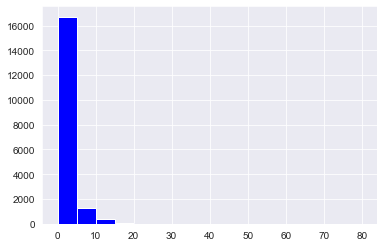

In [255]:
plt.hist(clean_taxi_df.tip_amount.values, 16, histtype='bar', facecolor='b')
plt.show()

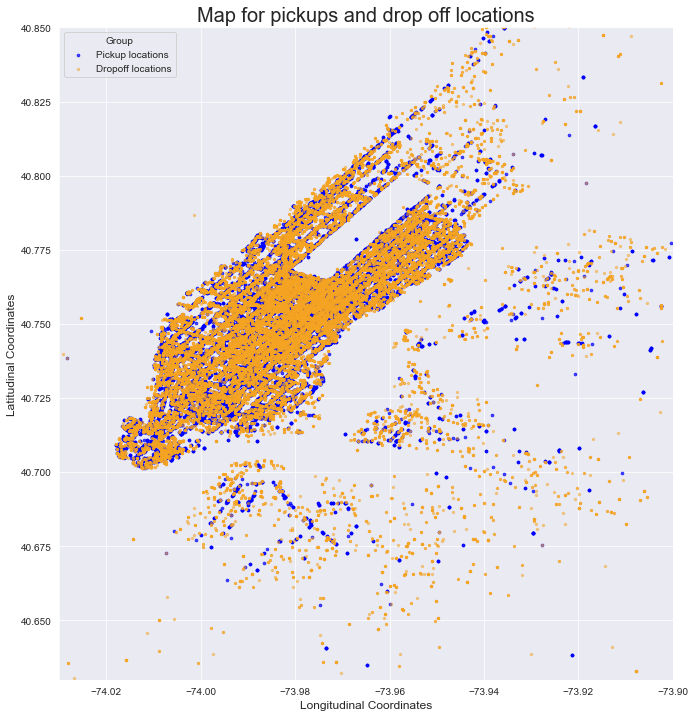

In [256]:
#visualization on the pickup and drop off locations
samplesize = 41013
indices = np.random.choice(clean_taxi_df.index, samplesize)
pickup_xaxis = clean_taxi_df.pickup_longitude[indices].values
pickup_yaxis = clean_taxi_df.pickup_latitude[indices].values
dropoff_xaxis = clean_taxi_df.dropoff_longitude[indices].values
dropoff_yaxis = clean_taxi_df.dropoff_latitude[indices].values

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(11, 12))
ax.scatter(pickup_xaxis, pickup_yaxis, s=7, color='blue', alpha=0.7)
ax.scatter(dropoff_xaxis, dropoff_yaxis, s=5, color='#F5A422', alpha=0.5)
ax.set_xlim([-74.03, -73.90])
ax.set_ylim([40.63, 40.85])
ax.set_xlabel("Longitudinal Coordinates", fontsize = 12)
ax.set_ylabel("Latitudinal Coordinates", fontsize = 12)
ax.legend(['Pickup locations','Dropoff locations'],loc='best',title='Group')
ax.set_title('Map for pickups and drop off locations', fontsize = 20)
plt.show()

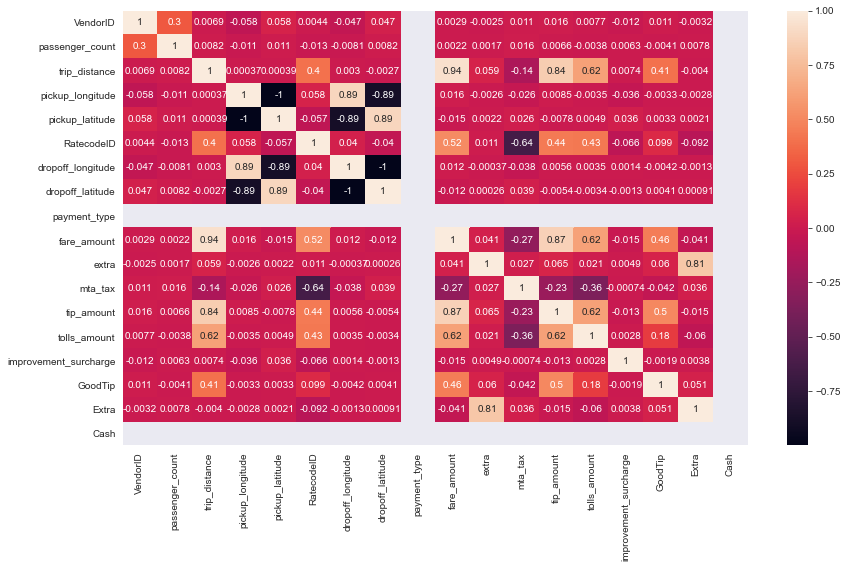

In [257]:
# T3.1: Create a heatmap to pinpoint the columns in the 'clean_taxi_df' DataFrame exhibiting high correlation.
plt.figure(figsize=(14, 8))
sns.heatmap(data=clean_taxi_df.corr(), annot=True) # 'annot=True' fills the R values in the heatmap cells.
plt.show()

In [258]:
# Visualization plot based on the analysis 
def plotGraph (self, xLabel, yLabel, title, groupBy, plotType) :
        fig,ax = plt.subplots(1,figsize = (7,4))
        #checking the type of payment mode
        ax = self.groupby([groupBy]).size().plot(kind=plotType)
        ax.set_xlabel(xLabel, fontsize=12)
        ax.set_ylabel(yLabel, fontsize=12)
        ax.set_title(title, fontsize=15)
        ax.tick_params(labelsize=12)
        plt.show()   

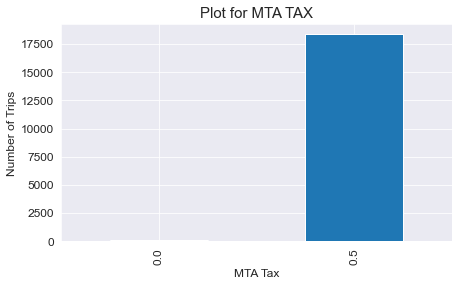

In [259]:
plotGraph(clean_taxi_df,'MTA Tax','Number of Trips','Plot for MTA TAX', 'mta_tax','bar')

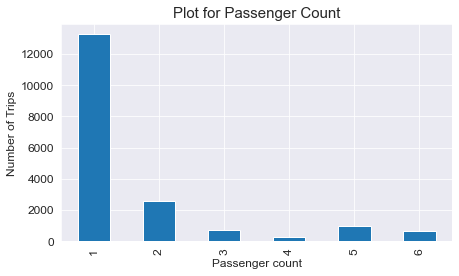

In [260]:
#Visualization for the Passenger count Vs Number of trips
plotGraph(clean_taxi_df,'Passenger count','Number of Trips','Plot for Passenger Count', 'passenger_count','bar')

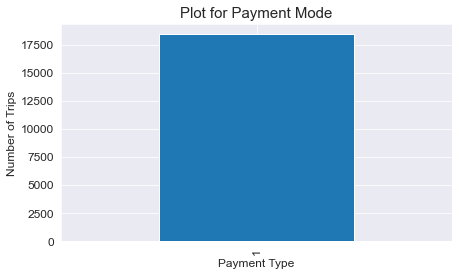

In [261]:
# Visualization for the Payment Type Vs Number of trips
plotGraph(clean_taxi_df,'Payment Type','Number of Trips','Plot for Payment Mode', 'payment_type','bar')

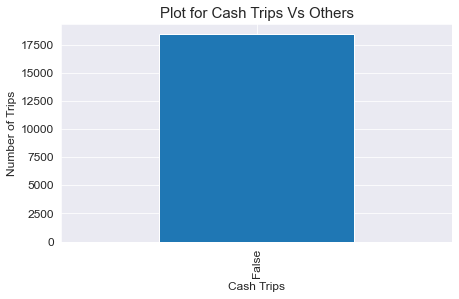

In [262]:
# Visualization for the Cash Trips Vs Others of trips
plotGraph(clean_taxi_df,'Cash Trips','Number of Trips','Plot for Cash Trips Vs Others', 'Cash','bar')

It seems from above plots and heatmap, all the trips in this dataset has used cash as method of payment. So 'Payment Type' and 'Cash' can be dropped. 

In [263]:
clean_taxi_df = clean_taxi_df.drop(columns=['payment_type','Cash' ], axis=1) 

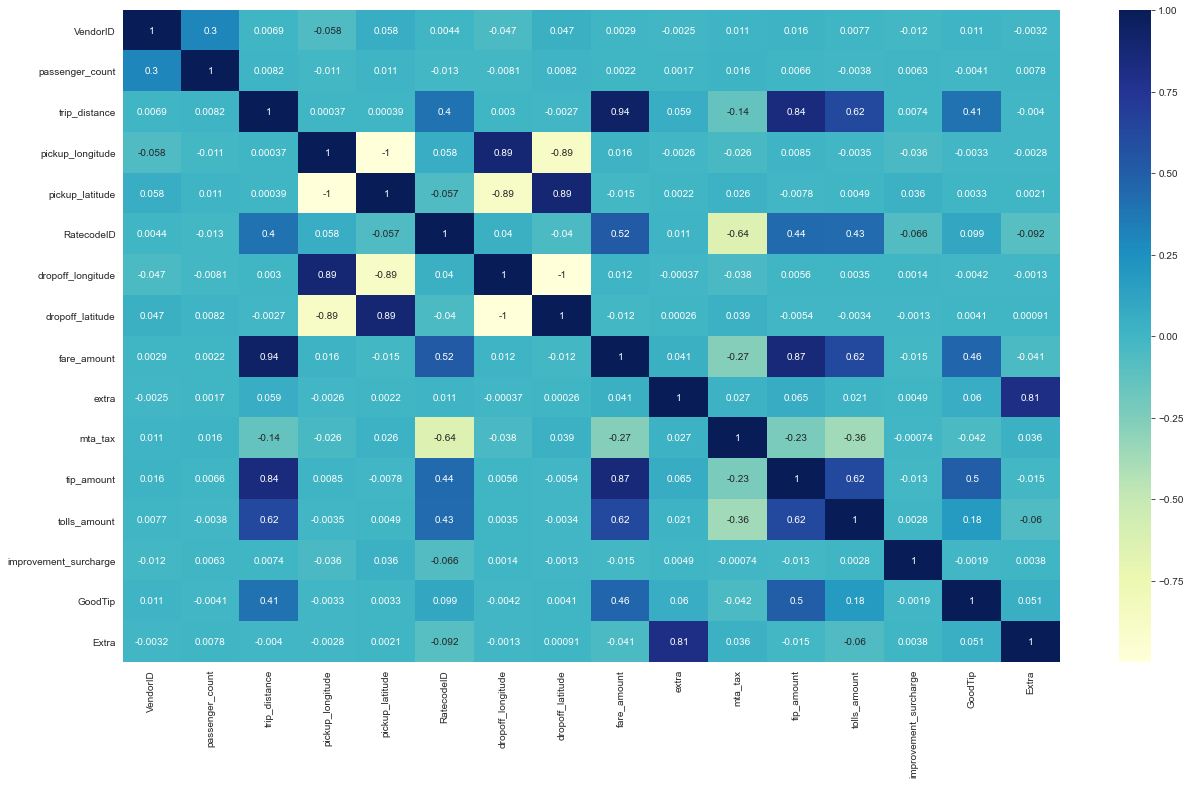

In [264]:
# T3.1: Create a heatmap to pinpoint the columns in the 'clean_taxi_df' DataFrame exhibiting high correlation.
plt.figure(figsize=(21, 12))
sns.heatmap(data=clean_taxi_df.corr(), annot=True, cmap='YlGnBu')
plt.show()

## Dataset Preprocessing

In [265]:
#Converting pickup and drop off dates times to datetime format
clean_taxi_df['tpep_dropoff_datetime'] = pd.to_datetime(clean_taxi_df['tpep_dropoff_datetime'])
clean_taxi_df['tpep_pickup_datetime'] = pd.to_datetime(clean_taxi_df['tpep_pickup_datetime'])

In [266]:
# extract pickup and dropoff hour
clean_taxi_df['pickup_hour'] = clean_taxi_df['tpep_pickup_datetime'].dt.hour
clean_taxi_df['dropoff_hour'] = clean_taxi_df['tpep_dropoff_datetime'].dt.hour

In [267]:
# extract pickup and dropoff day of week
clean_taxi_df['pickup_day'] = clean_taxi_df['tpep_pickup_datetime'].dt.weekday
clean_taxi_df['dropoff_day'] = clean_taxi_df['tpep_dropoff_datetime'].dt.weekday

In [268]:
# compute trip time in minutes
clean_taxi_df['trip_time'] = (clean_taxi_df['tpep_dropoff_datetime'] - clean_taxi_df['tpep_pickup_datetime']).astype('timedelta64[m]')

In [269]:
# drop the pickup and dropoff datetimes
clean_taxi_df = clean_taxi_df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

In [270]:
clean_taxi_df.head()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,fare_amount,...,tip_amount,tolls_amount,improvement_surcharge,GoodTip,Extra,pickup_hour,dropoff_hour,pickup_day,dropoff_day,trip_time
2,1,1,1.80,-73.984863,40.741970,1,N,-73.967613,40.760391,8.5,...,1.50,0.0,0.3,False,True,20,21,4,4,9.0
3,1,1,2.40,-73.998344,40.740376,1,N,-74.005295,40.709438,11.5,...,3.20,0.0,0.3,True,True,20,21,4,4,14.0
4,2,1,1.09,-73.993179,40.729870,1,N,-74.004288,40.716309,6.0,...,1.20,0.0,0.3,False,True,20,20,4,4,6.0
5,1,1,1.00,-73.989952,40.733097,1,N,-74.000359,40.727215,7.0,...,1.00,0.0,0.3,False,True,20,21,4,4,8.0
7,2,1,0.83,-73.972481,40.756981,1,N,-73.981377,40.749512,5.0,...,1.26,0.0,0.3,False,True,20,21,4,4,3.0


## Data Exploration 2

In [271]:
def line_plot(width, height, x_values, y_values, color, label):
  plt.figure(figsize=(width, height))
  plt.plot(x_values, y_values, color=color, label=label)
  plt.legend()
  plt.show()

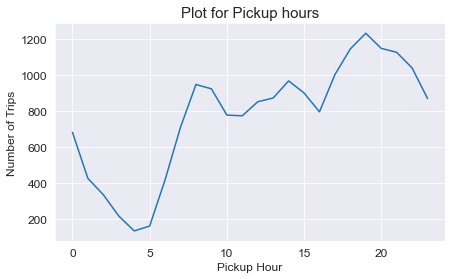

In [272]:
#How tip amount has changed according to pickup hour
plotGraph(clean_taxi_df,'Pickup Hour','Number of Trips','Plot for Pickup hours', 'pickup_hour','line')

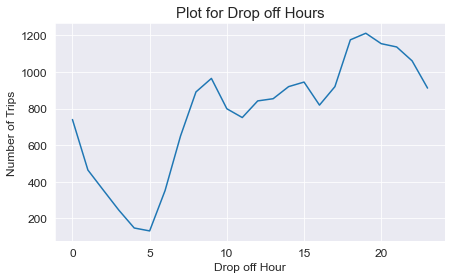

In [273]:
#How tip amount has changed according to Drop off hours
plotGraph(clean_taxi_df,'Drop off Hour','Number of Trips','Plot for Drop off Hours', 'dropoff_hour','line')

From above graphs, it can be seen that most of the trips was done in from around 09.00 to 20.00 and around 05.00 least number of trips were completed while highest number of trips were completed around 19.00

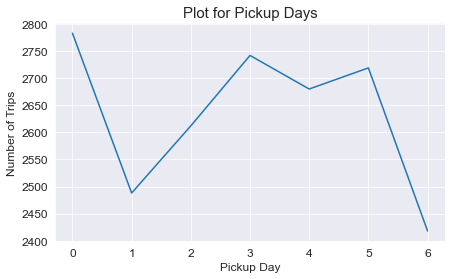

In [274]:
#How tip amount has changed according to Pickup Day
plotGraph(clean_taxi_df,'Pickup Day','Number of Trips','Plot for Pickup Days', 'pickup_day','line')

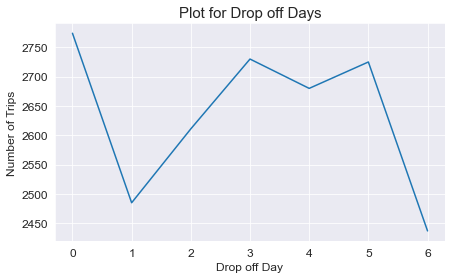

In [275]:
#How tip amount has changed according to Drop off Day
plotGraph(clean_taxi_df,'Drop off Day','Number of Trips','Plot for Drop off Days', 'dropoff_day','line')

Above graphs shows that most trips were completed on Mondays where as least number of trips were done in Sundays and Tuesdays.

## Feature Selection

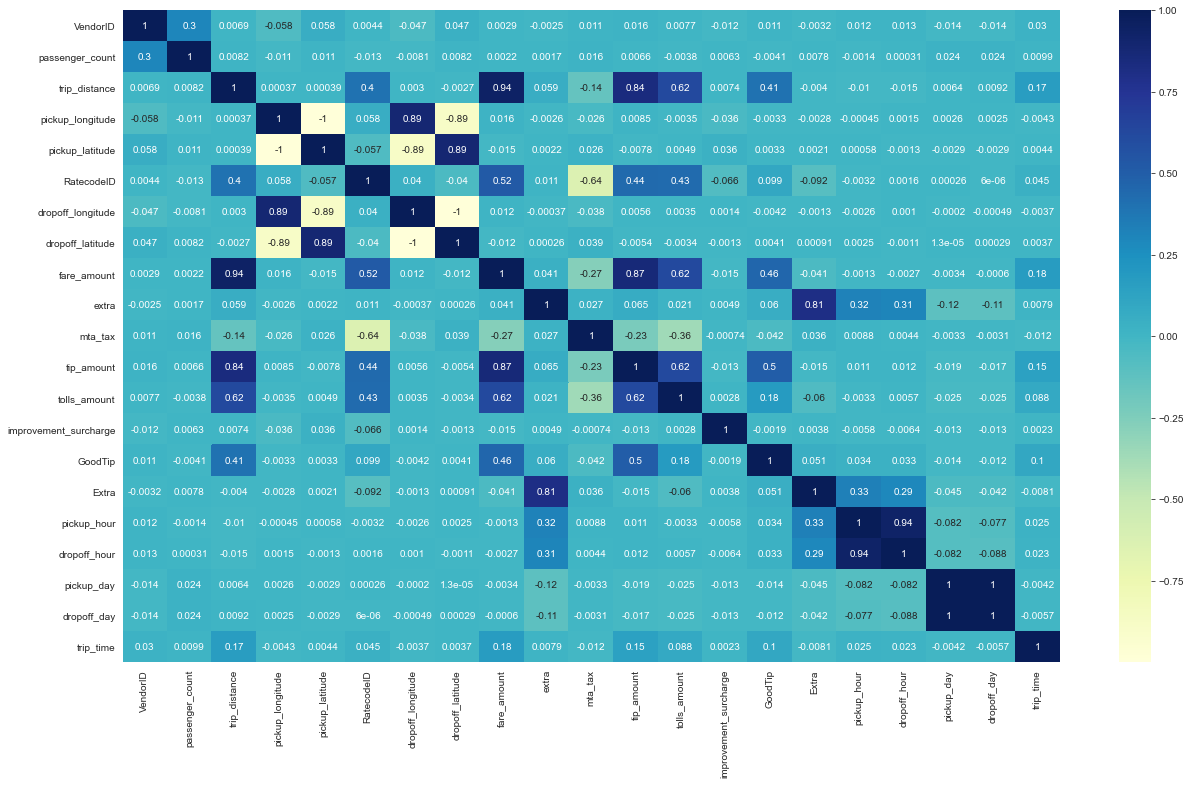

In [276]:
# T3.1: Create a heatmap to pinpoint the columns in the 'clean_taxi_df' DataFrame exhibiting high correlation.
plt.figure(figsize=(21, 12))
sns.heatmap(data=clean_taxi_df.corr(), annot=True, cmap='YlGnBu')
plt.show()

From above heatmap, we can identify most corelated features to target feature 'tip_amount'. 
They are 'trip_distance', 'RatecodeID', 'fare_amount', 'mta_tax', 'tolls_amount', 'GoodTip' and 'trip_time'.
These feature are selected to build the models.

In [277]:
clean_taxi_df = clean_taxi_df.loc[:,['tip_amount','trip_distance', 'RatecodeID', 'fare_amount', 'mta_tax', 'tolls_amount', 'GoodTip','trip_time']]

In [278]:
# some features are categorical, So need to encode them
# to encode them, use one-hot encoding from the Pandas package
get_dummy_col = ["RatecodeID"]
proc_taxi_df = pd.get_dummies(clean_taxi_df, columns = get_dummy_col)

In [279]:
proc_taxi_df.head()

,tip_amount,trip_distance,fare_amount,mta_tax,tolls_amount,GoodTip,trip_time,RatecodeID_1,RatecodeID_2,RatecodeID_3,RatecodeID_4,RatecodeID_5
2,1.50,1.80,8.5,0.5,0.0,False,9.0,1,0,0,0,0
3,3.20,2.40,11.5,0.5,0.0,True,14.0,1,0,0,0,0
4,1.20,1.09,6.0,0.5,0.0,False,6.0,1,0,0,0,0
5,1.00,1.00,7.0,0.5,0.0,False,8.0,1,0,0,0,0
7,1.26,0.83,5.0,0.5,0.0,False,3.0,1,0,0,0,0


In [280]:
proc_taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18442 entries, 2 to 28451
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tip_amount     18442 non-null  float64
 1   trip_distance  18442 non-null  float64
 2   fare_amount    18442 non-null  float64
 3   mta_tax        18442 non-null  float64
 4   tolls_amount   18442 non-null  float64
 5   GoodTip        18442 non-null  bool   
 6   trip_time      18442 non-null  float64
 7   RatecodeID_1   18442 non-null  uint8  
 8   RatecodeID_2   18442 non-null  uint8  
 9   RatecodeID_3   18442 non-null  uint8  
 10  RatecodeID_4   18442 non-null  uint8  
 11  RatecodeID_5   18442 non-null  uint8  
dtypes: bool(1), float64(6), uint8(5)
memory usage: 1.6 MB


In [281]:
# extract the labels from the dataframe
y = proc_taxi_df[['tip_amount']].values.astype('float32')

In [282]:
# drop the target variable from the feature matrix
proc_taxi_df = proc_taxi_df.drop(['tip_amount'], axis=1)

In [283]:
# get the feature matrix used for training
X = proc_taxi_df.values

In [284]:
# normalize the feature matrix
X = normalize(X, axis=1, norm='l1', copy=False)

In [285]:
# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (18442, 11) y.shape= (18442, 1)


### Dataset Split - Train and Test Data

In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (12909, 11) Y_train.shape= (12909, 1)
X_test.shape= (5533, 11) Y_test.shape= (5533, 1)


## Linear Regression Model

In [287]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)

In [288]:
lr.score(X_train, y_train)

0.5773138348764566

In [289]:
#R squared value calculation for random forest
test_score = r2_score(y_test, y_test_pred)
print("R Squared value for Linear regression model :",test_score)

R Squared value for Linear regression model : 0.6433660531729661


In [290]:
#Root Mean squared error calculation to test the performance for linear regression model
rms_LR = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Mean squared Error for Linear regression :",rms_LR)

Mean squared Error for Linear regression : 1.331904664111515


## Random Forest Model

In [291]:
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train.ravel())
y_test_pred = rf.predict(X_test)

In [292]:
rf.score(X_train, y_train)

0.9578833584856455

In [293]:
#R squared value calculation for random forest
test_score = r2_score(y_test, y_test_pred)
print("R Squared value for random forest regression model :",test_score)

R Squared value for random forest regression model : 0.8092279089510634


In [294]:
#Root Mean squared error calculation to test the performance for random forest model
rms_RF = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Mean squared Error for random forest regression :",rms_RF)

Mean squared Error for random forest regression : 0.9741351621472841


## Decision Tree Model

In [295]:
DT = DecisionTreeRegressor(random_state = 0)
DT.fit(X_train, y_train)
y_test_pred = DT.predict(X_test)

In [296]:
DT.score(X_train, y_train)

0.9891921824372988

In [297]:
#R squared value calculation for Decision Tree 
test_score = r2_score(y_test, y_test_pred)
print("R Squared value for random Decision Tree model :",test_score)

R Squared value for random Decision Tree model : 0.6896240859921658


In [298]:
#Root Mean squared error calculation to test the performance for Decision Tree model
rms_DT = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Mean squared Error for random Decision Tree :",rms_DT)

Mean squared Error for random Decision Tree : 1.2425269166429092
